<a href="https://colab.research.google.com/github/astrodeepnet/sbi_experiments/blob/PosterMoriond2022/notebooks/Plots_WLModelexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple lensing simulator in jax


In [1]:
!pip install --quiet jax-cosmo numpyro dm-haiku optax
!pip install --quiet git+https://github.com/EiffL/powerbox-jax.git@numpyro
!pip install --quiet git+https://github.com/astrodeepnet/sbi_experiments.git

     |████████████████████████████████| 283 kB 13.3 MB/s 
     |████████████████████████████████| 282 kB 53.2 MB/s 
     |████████████████████████████████| 287 kB 74.3 MB/s 
     |████████████████████████████████| 126 kB 57.7 MB/s 
     |████████████████████████████████| 65 kB 3.8 MB/s 
     |████████████████████████████████| 109 kB 13.9 MB/s 


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import powerbox_jax as pbj

In [4]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

### WL model

In [5]:
def model(N=64,                # number of pixels on the map
          map_size=10,         # map size in deg.
          gal_per_arcmin2=10,   
          sigma_e=0.2):      
    
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * pi    # radians

    
    # Sampling cosmology
    omega_c = numpyro.sample('omega_c', dist.Normal(0.3, 0.05))
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0.8, 0.05))
    
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    
    # Defining the function that will compute the power spectrum of the field
    # Create an interpolation array for the cls to avoid far too many computations
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer], nonlinear_fn=jc.power.linear)[0]
    # Warning!!!!: I was too lazy to figure out the proper conversion from k to ell 
    P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
    
    pb = pbj.PowerBox(
        N=N,                                   # Number of grid-points in the box
        dim=2,                                 # 2D box
        pk = P,                                # The power-spectrum
        boxlength = map_size,                  # Size of the box (sets the units of k in pk)
        vol_normalised_power=True,             # normalise power by volume
        supplied_freqs=None
    )
      
    # Sampling field
    field = pb.delta_x()
    
    # Adding "observational noise"
    x = numpyro.sample('x', dist.Independent(dist.Normal(field, sigma_e/jnp.sqrt(gal_per_arcmin2 * pix_area)), 2))
    
    return x

In [6]:
sample_map = seed(model, jax.random.PRNGKey(0))

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


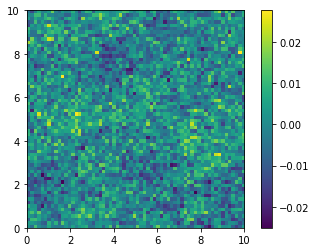

In [7]:
m = sample_map()
imshow(m, extent=(0,10,0,10))
colorbar()
show()

In [8]:
# Create our fiducial observations
fiducial_model = condition(model, {'omega_c': 0.27, 'sigma_8': 0.77})
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(12345670))
m_data = sample_map_fiducial()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


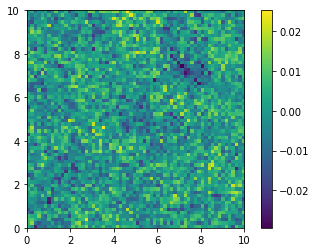

In [9]:
imshow(m_data, extent=(0,10,0,10))
colorbar()
show()

### Training a neural network to learn a good summary stat

In [10]:
import haiku as hk
import optax

In [11]:
master_seed = hk.PRNGSequence(42)

In [12]:
# Now we define a model conditioned on these values
def eval_model(key):

  cond_model = seed(model, key)
  model_trace = trace(cond_model).get_trace()
  return jnp.array([model_trace['omega_c']['value'], model_trace['sigma_8']['value'] ]) , model_trace['x']['value']

In [13]:
@jax.jit
def get_batch(key, batch_size=128):

  p, x = jax.vmap(eval_model)(jax.random.split(key, batch_size))
  
  return p, x

In [14]:
p, x = get_batch(next(master_seed))

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [15]:
class Compressor(hk.Module):
  """This is a NN that predicts the score."""
  def __call__(self, x):
    x = x[..., jnp.newaxis]
    net_x = hk.Conv2D(32, 3, 2)(x) # in 32
    net_x = jax.nn.leaky_relu(net_x)
    net_x = hk.Conv2D(64, 3, 2)(net_x) # in 16
    net_x = jax.nn.leaky_relu(net_x)
    net_x = hk.Conv2D(128, 3, 2)(net_x)# in 8
    net_x = jax.nn.leaky_relu(net_x)
    net_x = hk.AvgPool(16,8,'SAME')(net_x) # in 2
    net_x = hk.Flatten()(net_x)

    # Bottleneck
    net_x = hk.Linear(2)(net_x)

    return net_x.squeeze()

In [16]:
compressor = hk.without_apply_rng(hk.transform(lambda x : Compressor()(x)))
rng_seq = hk.PRNGSequence(12)
params_compressor = compressor.init(next(rng_seq), jnp.zeros([1,64,64]))

In [17]:
def loss_fn(params, batch):
  out = jax.vmap(lambda p, x: compressor.apply(params, x.reshape([-1,64,64])))(*batch) # Here we extract the grad of the model
  return jnp.mean(jnp.sum((out - batch[0])**2, axis=1))

@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [18]:
from tqdm import tqdm
losses = []
master_seed = hk.PRNGSequence(0)

In [19]:
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_compressor)

In [20]:
it = 1000

for step in tqdm(range(it)):
  p, x = get_batch(next(master_seed))
  l, params_compressor, opt_state = update(params_compressor, opt_state, (p, x))
  losses.append(l)

100%|██████████| 1000/1000 [00:39<00:00, 25.17it/s]


In [21]:
learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_compressor)

In [22]:
it = 10000

for step in tqdm(range(it)):
  p, x = get_batch(next(master_seed))
  l, params_compressor, opt_state = update(params_compressor, opt_state, (p, x))
  losses.append(l)

100%|██████████| 10000/10000 [06:07<00:00, 27.17it/s]


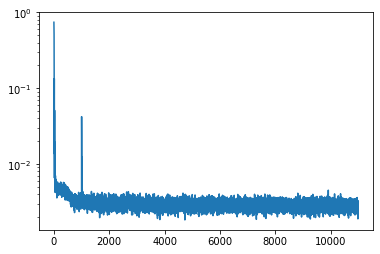

In [23]:
semilogy(array(losses))

In [24]:
p, x = get_batch(next(master_seed))
reg = compressor.apply(params_compressor, x)

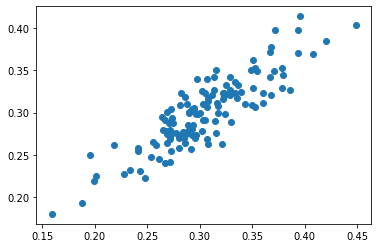

In [25]:
scatter(p[:,0], reg[:,0])

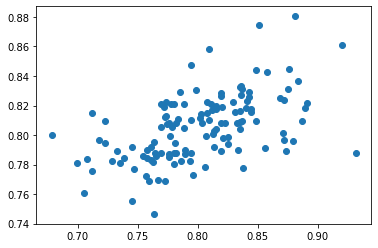

In [26]:
scatter(p[:,1], reg[:,1])

### Now that we have a compressor, let's try to learn the posterior

In [27]:
#Now we define a model conditioned on these values
def eval_model(params, key):
  oc = params[0]
  s8 = params[1]

  cond_model = condition(seed(model, key), {'omega_c': oc, 'sigma_8': s8})
  model_trace = trace(cond_model).get_trace()
  log_prob = model_trace['x']['fn'].log_prob(jax.lax.stop_gradient(model_trace['x']['value']))
  log_prob += model_trace['omega_c']['fn'].log_prob(model_trace['omega_c']['value'])
  log_prob += model_trace['sigma_8']['fn'].log_prob(model_trace['sigma_8']['value'])
  return log_prob, model_trace['x']['value']

@jax.jit
def get_batch(key, batch_size=1000):

  # Randomly draw from the prior
  key1, key2, key3 = jax.random.split(key, 3)
  oc = tfd.Normal(0.3, 0.05).sample(batch_size, seed=key1)
  s8 = tfd.Normal(0.8, 0.05).sample(batch_size, seed=key2)
  params_ref = jnp.stack([oc,s8], axis=1)

  score, x = jax.vmap(jax.grad(eval_model, has_aux=True))(params_ref,
                                                          jax.random.split(key3, batch_size))
  
  return params_ref, x, score 

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


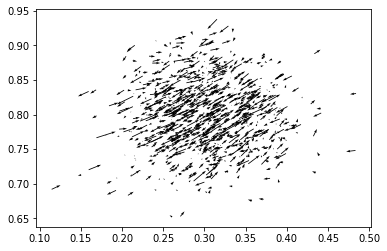

In [28]:
p, x, score = get_batch(next(master_seed))
quiver(p[:,0], p[:,1], score[:,0], score[:,1])

In [29]:
from sbiexpt.bijectors import MixtureAffineSigmoidBijector 

In [30]:
d = 2

class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __init__(self, y, *args, **kwargs):
    self.y = y
    super(CustomCoupling, self).__init__(*args, **kwargs)

  def __call__(self, x, output_units, **condition_kwargs):

    net = jnp.concatenate([x, self.y], axis=-1)
    # NN to get a b and c
    net = hk.Linear(128, name='l1')(net)
    net = jax.nn.silu(net) # silu = x*sigmoid(x)
    net = hk.Linear(128, name='l2')(net)
    net = jax.nn.silu(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components = 16
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p   = jax.nn.softmax(hk.Linear(n_components, name='l6')(net))
    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c, p)

class Flow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self, y):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b2')),
            tfb.Permute([1,0]),
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.MultivariateNormalDiag(jnp.array([0.3,0.8]), scale_identity_multiplier=0.05),
            bijector=chain)
      return nvp

In [46]:
nvp = hk.without_apply_rng(hk.transform(lambda p,y : Flow()(y).log_prob(p).squeeze()))

In [47]:
def loss_fn(params, batch, score, weight):
  y = compressor.apply(params_compressor, batch[1])
  log_prob, out = jax.vmap(jax.value_and_grad(lambda p, x: nvp.apply(params, p.reshape([-1,2]), x.reshape([-1,2]))))(batch[0], y) # Here we extract the grad of the model
  return -jnp.mean(log_prob) + jnp.mean(jnp.sum((out - score)**2, axis=1))*weight 

@jax.jit
def update(params, opt_state, batch, score, weight):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score, weight)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [48]:
# Metrics : neg log prob 
precision = 1000
oc = jnp.full(precision, 0.27)
s8 = jnp.full(precision, 0.77)
theta = jnp.stack([oc,s8], axis=1)

@jax.jit
def get_truth(theta, key):

  oc = theta[0]
  s8 = theta[1]

  cond_model = condition(seed(model, key), {'omega_c': oc, 'sigma_8': s8})
  model_trace = trace(cond_model).get_trace()
  return model_trace['x']['value']


# Negative log prob 
def neg_log_prob(params, params_compressor, theta, precision):

  master_seed = hk.PRNGSequence(1)
  x = jax.vmap(get_truth)(theta, jax.random.split(next(master_seed), precision))
  y = jax.vmap(lambda x: compressor.apply(params_compressor, x.reshape([-1,64,64])))(x)

  return - jnp.mean(jax.vmap((lambda p, x: nvp.apply(params, p.reshape([-1,2]), x.reshape([-1,2]))))(theta, y))

In [120]:
nlp_nll = []

In [121]:
nlp_nllscore = []

##### Results loss = nll

100%|██████████| 10000/10000 [02:36<00:00, 63.94it/s]


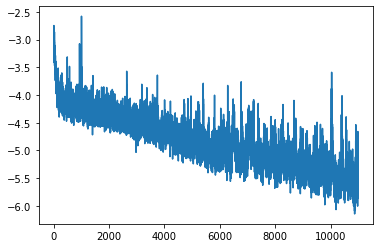

In [122]:
nb_simu = 50
size_mini_batch = 40
weight  = 0


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [123]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

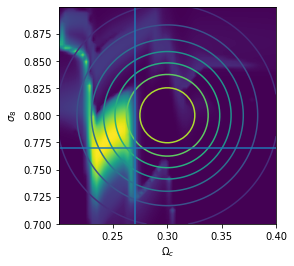

In [124]:
# Trained with NLL  on shuffled 50 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [125]:
nlp_nll.append(neg_log_prob(params, params_compressor, theta, precision))

In [126]:
nlp_nll[-1]

DeviceArray(-3.8082957, dtype=float32)

100%|██████████| 10000/10000 [02:38<00:00, 63.19it/s]


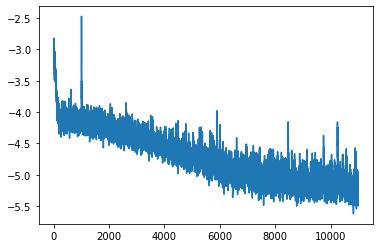

In [127]:
nb_simu = 100
size_mini_batch = 80
weight  = 0


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [128]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

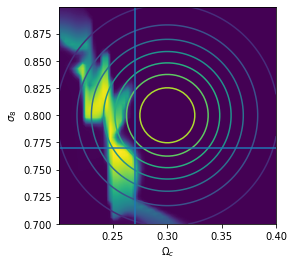

In [129]:
# Trained with NLL  on shuffled 100 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [130]:
nlp_nll.append(neg_log_prob(params, params_compressor, theta, precision))

In [131]:
nlp_nll[-1]

DeviceArray(-3.8036873, dtype=float32)

100%|██████████| 10000/10000 [02:29<00:00, 66.90it/s]


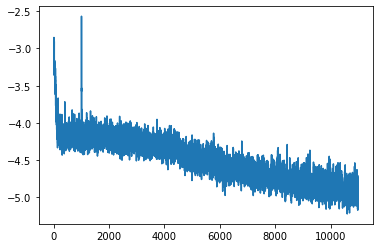

In [132]:
nb_simu = 150
size_mini_batch = 110
weight  = 0


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [133]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

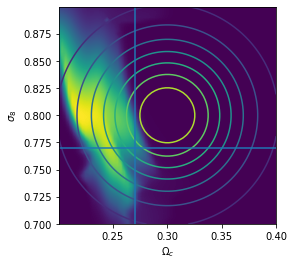

In [134]:
# Trained with NLL  on shuffled 150 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [135]:
nlp_nll.append(neg_log_prob(params, params_compressor, theta, precision))

In [136]:
nlp_nll[-1]

DeviceArray(-4.3242464, dtype=float32)

100%|██████████| 10000/10000 [02:44<00:00, 60.69it/s]


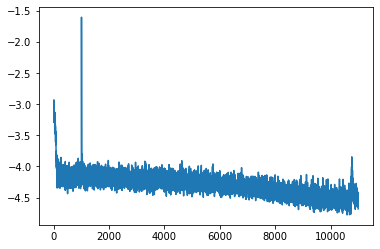

In [137]:
nb_simu = 200
size_mini_batch = 140
weight  = 0


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [138]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

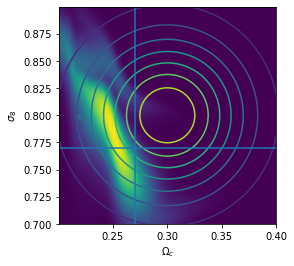

In [139]:
# Trained with NLL  on shuffled 150 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [140]:
nlp_nll.append(neg_log_prob(params, params_compressor, theta, precision))

In [141]:
nlp_nll[-1]

DeviceArray(-4.4308605, dtype=float32)

100%|██████████| 10000/10000 [04:00<00:00, 41.63it/s]


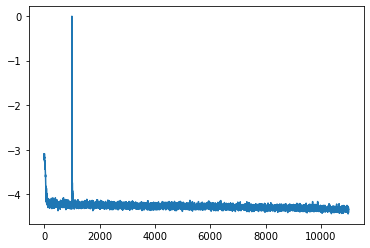

In [142]:
nb_simu = 1000
size_mini_batch = 800
weight  = 0


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [143]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

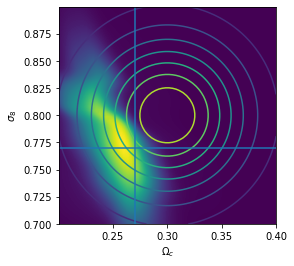

In [144]:
# Trained with NLL  on shuffled 1000 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [145]:
nlp_nll.append(neg_log_prob(params, params_compressor, theta, precision))

In [146]:
nlp_nll[-1]

DeviceArray(-4.798219, dtype=float32)

##### Results loss = nll +score /1000

100%|██████████| 10000/10000 [02:52<00:00, 57.97it/s]


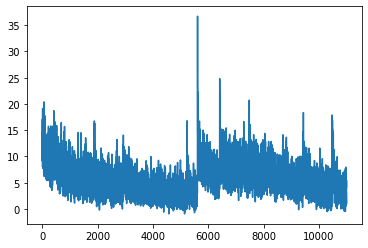

In [147]:
nb_simu = 50
size_mini_batch = 40
weight  = 1e-3


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [148]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

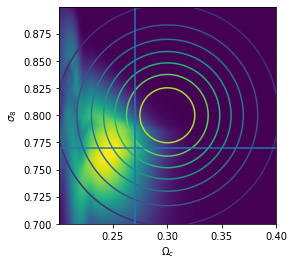

In [149]:
# Trained with NLL + score/ 1000 on shuffled 50 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [150]:
nlp_nllscore.append(neg_log_prob(params, params_compressor, theta, precision))

In [151]:
nlp_nllscore[-1]

DeviceArray(-4.443541, dtype=float32)

100%|██████████| 10000/10000 [02:41<00:00, 61.80it/s]


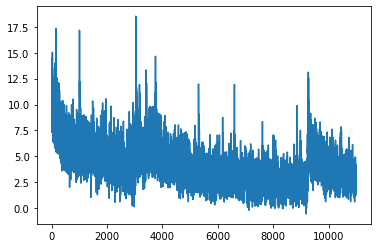

In [152]:
nb_simu = 100
size_mini_batch = 80
weight  = 1e-3


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [153]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

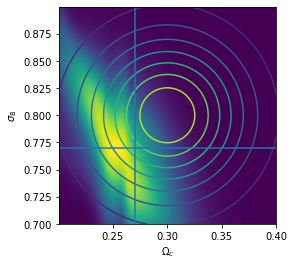

In [154]:
# Trained with NLL + score/ 1000 on shuffled 100 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [155]:
nlp_nllscore.append(neg_log_prob(params, params_compressor, theta, precision))

In [156]:
nlp_nllscore[-1]

DeviceArray(-4.242141, dtype=float32)

100%|██████████| 10000/10000 [02:31<00:00, 65.93it/s]


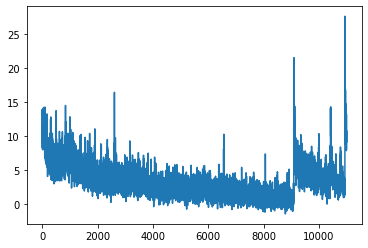

In [157]:
nb_simu = 150
size_mini_batch = 110
weight  = 1e-3


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [158]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

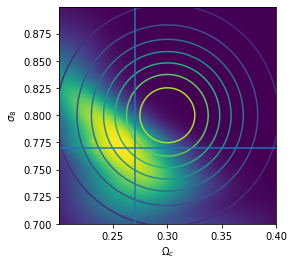

In [159]:
# Trained with NLL + score/ 1000 on shuffled 150 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [160]:
nlp_nllscore.append(neg_log_prob(params, params_compressor, theta, precision))

In [161]:
nlp_nllscore[-1]

DeviceArray(-4.226684, dtype=float32)

100%|██████████| 10000/10000 [03:09<00:00, 52.67it/s]


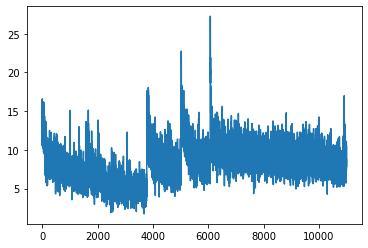

In [162]:
nb_simu = 200
size_mini_batch = 140
weight  = 1e-3


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [163]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

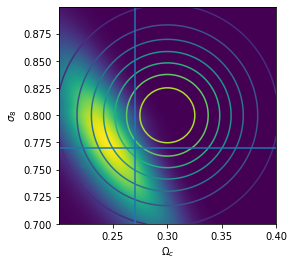

In [164]:
# Trained with NLL + score/ 1000 on shuffled 200 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [165]:
nlp_nllscore.append(neg_log_prob(params, params_compressor, theta, precision))

In [166]:
nlp_nllscore[-1]

DeviceArray(-4.338909, dtype=float32)

100%|██████████| 10000/10000 [04:05<00:00, 40.71it/s]


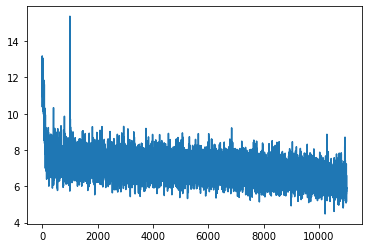

In [169]:
nb_simu = 1000
size_mini_batch = 800
weight  = 1e-3


# init model 
rng_seq = hk.PRNGSequence(12)
params = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

p, x, score = get_batch(jax.random.PRNGKey(0))

it = 1000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  # p, x, score = get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  inds = np.random.randint(0, nb_simu, size_mini_batch)
  l, params, opt_state = update(params, opt_state, (p[inds], x[inds]), score[inds], weight)
  losses.append(l)

plot(array(losses)[:])

In [170]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.2,0.4,64),
                 jnp.linspace(0.7,0.9,64)), axis=-1)
ps = p.reshape([-1, 2])

# Getting value of the score as predicted by the NN
y = compressor.apply(params_compressor,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

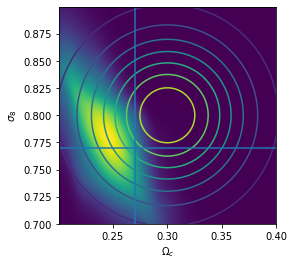

In [171]:
# Trained with NLL + score/ 1000 on shuffled 1000 samples
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.05).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

In [172]:
nlp_nllscore.append(neg_log_prob(params, params_compressor, theta, precision))

In [173]:
nlp_nllscore[-1]

DeviceArray(-4.594867, dtype=float32)

#### Metric

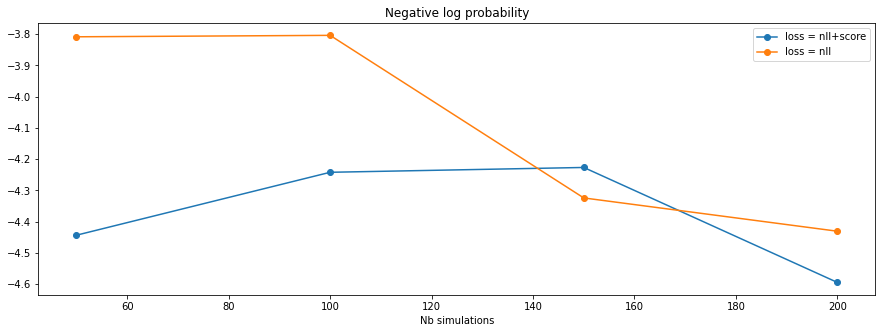

In [177]:
plt.figure(figsize = (15,5))
plt.plot([50,100,150,200], nlp_nllscore, label = 'loss = nll+score', marker = 'o')
plt.plot([50,100,150,200], nlp_nll, label = 'loss = nll', marker = 'o')
plt.legend()
plt.xlabel('Nb simulations')
plt.title('Negative log probability')

plt.savefig('/content/metric.pdf')